In [1]:
import sqlite3
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt


In [3]:
DB_PATH = Path("../Data/DB/spacex.db")
PROCESSED_DIR = Path("../Data/Procesed")
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

conn = sqlite3.connect(DB_PATH)

# Load tables
df_launches = pd.read_sql_query("SELECT * FROM launches", conn)
df_rockets = pd.read_sql_query("SELECT * FROM rockets", conn)
df_launchpads = pd.read_sql_query("SELECT * FROM launchpads", conn)

conn.close()


In [4]:

# Build master dataset
master = df_launches.merge(
    df_rockets,
    how="left",
    left_on="rocket_id",
    right_on="id",
    suffixes=("_launch", "_rocket"),
)

master = master.merge(
    df_launchpads,
    how="left",
    left_on="launchpad_id",
    right_on="id",
    suffixes=("", "_launchpad"),
)

master.to_csv(PROCESSED_DIR / "mission_report.csv", index=False)


=== Mission Debrief ===

1) Workhorse rocket (most missions):
name_rocket
Falcon 9        195
Falcon 1          5
Falcon Heavy      5
Name: spacex_id_launch, dtype: int64

2) Reliability (success rate, rockets with >=5 launches):
             launches  success_rate
name_rocket                        
Falcon 9          178      0.988764
Falcon 1            5      0.400000

3) Launches per year:
year
2006     1
2007     1
2008     2
2009     1
2010     2
2012     2
2013     3
2014     6
2015     7
2016     9
2017    18
2018    21
2019    13
2020    26
2021    31
2022    62
Name: spacex_id_launch, dtype: int64


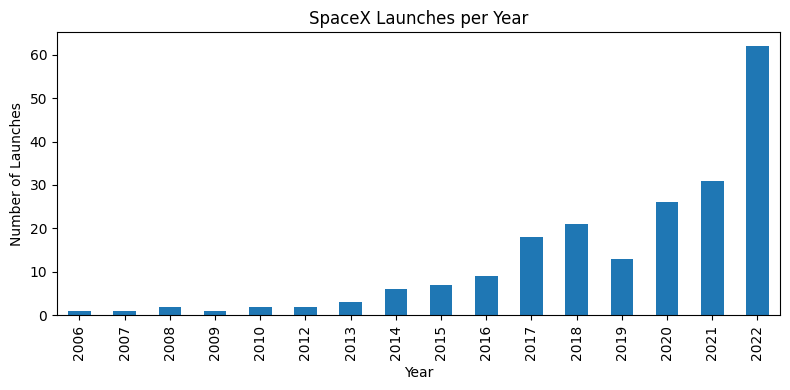

In [5]:

# --- Analysis ---
print("=== Mission Debrief ===")

# Workhorse rocket: most missions
workhorse = (
    master.groupby("name_rocket")["spacex_id_launch"]
    .count()
    .sort_values(ascending=False)
)
print("\n1) Workhorse rocket (most missions):")
print(workhorse.head(10))

# Reliability: highest success rate (>=5 launches)
reliability = (
    master.dropna(subset=["success"])
    .groupby("name_rocket")
    .agg(
        launches=("spacex_id_launch", "count"),
        success_rate=("success", "mean"),
    )
)
reliability_filtered = reliability[reliability["launches"] >= 5].sort_values(
    by="success_rate", ascending=False
)
print("\n2) Reliability (success rate, rockets with >=5 launches):")
print(reliability_filtered.head(10))

# Launch cadence: launches per year
master["date_utc"] = pd.to_datetime(master["date_utc"], errors="coerce")
master["year"] = master["date_utc"].dt.year
launches_per_year = master.groupby("year")["spacex_id_launch"].count()
print("\n3) Launches per year:")
print(launches_per_year)

plt.figure(figsize=(8, 4))
launches_per_year.plot(kind="bar")
plt.title("SpaceX Launches per Year")
plt.xlabel("Year")
plt.ylabel("Number of Launches")
plt.tight_layout()
plt.savefig(PROCESSED_DIR / "launches_per_year.png")


In [6]:

# Geography: region with most launches
by_region = (
    master.groupby("region")["spacex_id_launch"]
    .count()
    .sort_values(ascending=False)
)
print("\n4) Region with most launches:")
print(by_region.head(10))

# Failure analysis
failed = master[master["success"] == 0][
    ["name_launch", "date_utc", "details", "name_rocket", "region"]
].sort_values("date_utc")
print("\n5) Failed missions (name, date, details, rocket, region):")
print(failed.head(20))

failed.to_csv(PROCESSED_DIR / "failed_missions.csv", index=False)



4) Region with most launches:
region
Florida             170
California           30
Marshall Islands      5
Name: spacex_id_launch, dtype: int64

5) Failed missions (name, date, details, rocket, region):
    name_launch                  date_utc  \
0     FalconSat 2006-03-24 22:30:00+00:00   
1       DemoSat 2007-03-21 01:10:00+00:00   
2   Trailblazer 2008-08-03 03:34:00+00:00   
23        CRS-7 2015-06-28 14:21:00+00:00   
33       Amos-6 2016-09-01 13:07:00+00:00   

                                              details name_rocket  \
0    Engine failure at 33 seconds and loss of vehicle    Falcon 1   
1   Successful first stage burn and transition to ...    Falcon 1   
2   Residual stage 1 thrust led to collision betwe...    Falcon 1   
23  Launch performance was nominal until an overpr...    Falcon 9   
33  The rocket and Amos-6 payload were lost in a l...    Falcon 9   

              region  
0   Marshall Islands  
1   Marshall Islands  
2   Marshall Islands  
23           Flo